In [48]:
#Dependencies 
import requests
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import scipy.stats as st
from pathlib import Path

from api_key import yelp_api_key, mapbox_api_key
# C:\Users\nwf91\OneDrive\Desktop\VandyDataCourse\project-3\project-3\api_key.py
# C:\Users\nwf91\OneDrive\Desktop\VandyDataCourse\project-3\project-3\working_doc.ipynb

from pprint import pprint

In [5]:
# Test if the API keys are imported correctly
print(f"Yelp API Key: {yelp_api_key}")
print(f"Mapbox API Key: {mapbox_api_key}")

Yelp API Key: GfAgyvCCqzBJJrefnJOUX_fcJI02oK4PgB2mMkTwNmWSXDEPhJPU9kYctePGP49D0ujK3QqYE4_Iic-RfsWG_ULgbOWv8yx1jRUrgVpj50Vq6qws4Y1Nkn-n2_TgZnYx
Mapbox API Key: pk.eyJ1IjoibmJpb3JnOTkiLCJhIjoiY20weDd5OG43MDFxbDJzcHBwN2Y2aXUxYiJ9.U3TN-LcnCc7RnK25R74N5w


In [6]:
# Yelp API 

# Yelp API base URL for searching businesses
yelp_url = "https://api.yelp.com/v3/businesses/search"

# Location and other parameters
location = "san francisco"
term = "restaurants"  
limit = 40 # Maximum results per request 
offset = 0 
rounds = 6 

yelp_data = []

for round in range(rounds): 

    # Define the headers to include the API key
    headers = {
        "Authorization": f"Bearer {yelp_api_key}"
    }

    # Define the parameters for the API call
    yelp_params = {
        "location": location,
        "term": term,
        "limit": limit,
        "offset": offset 
    }

    # Make the GET request to the Yelp API
    yelp_response = requests.get(yelp_url, headers=headers, params=yelp_params)
        
    #Saving Yelp Data 
    # Check if the Yelp request was successful
    if yelp_response.status_code == 200:
        yelp_data_json = yelp_response.json()  # Convert the response to JSON format
        businesses = yelp_data_json.get("businesses", [])  # Extract the businesses from the response
        

        # Loop over the Yelp businesses and call WalkScore API for each business
        for business in businesses:
            business_name = business["name"]
            business_id = business["id"]
            latitude = business["coordinates"]["latitude"]
            longitude = business["coordinates"]["longitude"]
            address = ", ".join(business["location"]["display_address"])
            rating = business["rating"]
            review_count = business["review_count"]
            price = business.get("price", "N/A")  # Some businesses may not have a price listed
            bus_categories = ", ".join([category["title"] for category in business["categories"]]),
            transactions = business["transactions"]
            
            yelp_data.append({
                "Name" : business_name,
                "Business_ID": business_id,
                "Latitude": latitude, 
                "Longitude": longitude, 
                "Address": address,
                "Rating": rating,
                "Review_count": review_count,
                "Price": price, 
                "Categories":bus_categories,
                "Transactions": transactions
            })
        
    else:
        print(f"Error: {yelp_response.status_code} - {yelp_response.text}") 

    offset += 40



Extracting and Transforming Yelp Data

In [7]:
# Transform Yelp data and convert to CSV 
yelp_pd = pd.DataFrame(yelp_data)
yelp_pd

# Take ZIP codes out of address 
yelp_pd['ZIP'] = yelp_pd['Address'].str.extract(r'(\d{5})')

# Convert category column 'Transactions' into three boolean columns
yelp_pd['Pickup'] = yelp_pd['Transactions'].apply(lambda x: 'pickup' in x)
yelp_pd['Delivery'] = yelp_pd['Transactions'].apply(lambda x: 'delivery' in x)
yelp_pd['Restaurant_Reservation'] = yelp_pd['Transactions'].apply(lambda x: 'restaurant_reservation' in x)

#Create coordinates "LatLong" column from latitude & longitude 
yelp_pd['LatLong'] = yelp_pd['Latitude'].astype(str) + ',' + yelp_pd['Longitude'].astype(str)


yelp_pd = yelp_pd[['Name', 'Business_ID', 'Latitude', 'Longitude', 'LatLong', 'Address','Rating', 'Review_count', 'Price', 'ZIP', 'Pickup', 'Delivery', 'Restaurant_Reservation']]

# Dropping duplicate LatLong
yelp_pd = yelp_pd.drop(80)

yelp_pd['LatLong'].duplicated().sum()

# convert to CSV 
yelp_pd.to_csv("CSV_Outputs/Businesses.csv", index=False)

# yelp_pd.head(5)



In [12]:
yelp_pd.head(5)


,Name,Business_ID,Latitude,Longitude,LatLong,Address,Rating,Review_count,Price,ZIP,Pickup,Delivery,Restaurant_Reservation
0,Bottega,QueFVMcMlT-6aZFv2M47mg,37.754720,-122.421200,"37.75472,-122.4212","1132 Valencia St, San Francisco, CA 94158",4.3,1210,$$,94158,True,True,False
1,Fog Harbor Fish House,f-m7-hyFzkf0HSEeQ2s-9A,37.808673,-122.409821,"37.80867300000001,-122.409821","39 Pier, San Francisco, CA 94133",4.4,10964,$$,94133,False,False,True
2,Bettola,oK6DQM2ztdNwMAyJqGWZpg,37.782840,-122.463137,"37.78284,-122.463137","343 Clement St, San Francisco, CA 94118",4.4,40,N/A,94118,False,False,False
3,Marufuku Ramen,HHtpR0RslupSQ99GIIwW5A,37.785220,-122.431570,"37.78522,-122.43157","1581 Webster St, Ste 235, San Francisco, CA 94115",4.5,5281,$$,94115,True,True,False
4,Sotto Mare,8dUaybEPHsZMgr1iKgqgMQ,37.799790,-122.408340,"37.79979,-122.40834","552 Green St, San Francisco, CA 94133",4.3,5478,$$,94133,True,True,False


Pulling Categories from Yelp 

In [9]:
#TODO # Pull unique categories from Yelp_pd['Categories'] Column and create new table with those categories and IDs 
# Category_ID Category_Name 
categories_copy = yelp_pd['Categories'].copy()

# Step 2: Remove parentheses and split by ', ' to create a list of categories
categories_copy = categories_copy.apply(lambda x: x.strip('()').split(', '))

# Step 3: Flatten the list of all categories
all_categories = [category for sublist in categories_copy for category in sublist if category]

# Step 4: Get unique categories
unique_categories = set(all_categories)

# Display the unique categories
print(unique_categories)

KeyError: 'Categories'

MapBox API Call and Directions Estimate Loop 

In [13]:
#MapBox API 

#Loop for driving
#base url for mapbox 
mapbox_url = "https://api.mapbox.com/directions/v5/mapbox/"
st_coordinates = (37.787937, -122.407677) #Latitude, Longitude in Union Square, SF 
method = "driving"
driving_data = []

for row in yelp_data:
    bs_coordinates = (row['Longitude'], row['Latitude'])
    
    coordinates = f"{st_coordinates[1]},{st_coordinates[0]};{row['Longitude']},{row['Latitude']}"
    
    query_url = f"{mapbox_url}{method}/{coordinates}.json"

    #Mapbox paramaters 
    driving_params = {
        "access_token" : mapbox_api_key,
        "overview" : "full",
        # "annotations": "distance, duration"
    }
    
    #Get request for MapBox API 
    mapbox_response = requests.get(query_url, params = driving_params)
    # print(mapbox_response.json()) 
    #if successful, extract duration and distance 
    if mapbox_response.status_code == 200: 
        mapbox_data = mapbox_response.json()

        if 'routes' in mapbox_data and len(mapbox_data['routes']) > 0:
            distance = mapbox_data['routes'][0]['distance']  # Distance in meters
            duration = mapbox_data['routes'][0]['duration']  # Duration in seconds
            route_id = mapbox_data['uuid'] # route_id
            
            driving_data.append({
                "Route_ID": route_id,
                "Distance_Meters": distance, 
                "Duration_Seconds" : duration,
                "Latitude": bs_coordinates[1],
                "Longitude": bs_coordinates[0]
            })
            
        else:
            print(f"Error with MapBox API for {row['name']}: {mapbox_response.status_code}")




In [14]:
driving_pd = pd.DataFrame(driving_data)
driving_pd

# Cleaning up columns and rearranging 
driving_pd["Duration_Minutes"] = (driving_pd['Duration_Seconds']/60).round()
driving_pd['LatLong'] = driving_pd['Latitude'].astype(str) + ',' + driving_pd['Longitude'].astype(str)

driving_pd = driving_pd[['Route_ID', 'Distance_Meters', 'Duration_Seconds', 'Duration_Minutes', 'Latitude', 'Longitude', 'LatLong']]

driving_pd.head(5)

driving_pd = driving_pd.drop(80)

driving_pd['LatLong'].duplicated().sum()

# Converting to CSV 
driving_pd.to_csv("CSV_Outputs/Driving_Estimate.csv", index=False)


In [15]:
merged_df = yelp_pd.merge(driving_pd, on='LatLong', how='inner')
# yelp_pd['LatLong'].nunique()
# driving_pd['LatLong'].nunique()
merged_df.head(2)


,Name,Business_ID,Latitude_x,Longitude_x,LatLong,Address,Rating,Review_count,Price,ZIP,Pickup,Delivery,Restaurant_Reservation,Route_ID,Distance_Meters,Duration_Seconds,Duration_Minutes,Latitude_y,Longitude_y
0,Bottega,QueFVMcMlT-6aZFv2M47mg,37.754720,-122.421200,"37.75472,-122.4212","1132 Valencia St, San Francisco, CA 94158",4.3,1210,$$,94158,True,True,False,vGRbz0IE4rHwdfsf-JtHtVIPi4BRIpX0v7_zXgXQCNmr0N...,5125.704,1256.260,21.0,37.754720,-122.421200
1,Fog Harbor Fish House,f-m7-hyFzkf0HSEeQ2s-9A,37.808673,-122.409821,"37.80867300000001,-122.409821","39 Pier, San Francisco, CA 94133",4.4,10964,$$,94133,False,False,True,Rd-nbfVFx8vXTBOM_Cd1VjzQsuRs06Ipqji4al3qQUsEBt...,3392.329,899.855,15.0,37.808673,-122.409821


Merged Data Analysis


In [41]:
# Summary Stats 
sum_stats = merged_df.describe()
sum_stats

,Rating,Review_count,Distance_Meters,Duration_Seconds,Duration_Minutes,Latitude,Longitude
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,4.383402,959.211618,4073.137307,922.000033,15.356846,37.776967,-122.430013
std,0.265939,1626.441630,2422.988231,355.824741,5.948148,0.016208,0.024311
min,3.800000,7.000000,500.757000,180.138000,3.000000,37.731264,-122.506850
25%,4.200000,144.000000,2328.059000,642.454000,11.000000,37.764150,-122.439970
50%,4.400000,349.000000,3861.904000,925.404000,15.000000,37.777870,-122.430121
75%,4.600000,1091.000000,5284.655000,1155.896000,19.000000,37.787420,-122.411290
max,5.000000,12406.000000,16590.240000,1969.701000,33.000000,37.820673,-122.375020


In [44]:
# Correlation Coeffs

correlations = merged_df[['Rating', 'Review_count', 'Distance_Meters', 'Duration_Seconds', 'Duration_Minutes', 'Pickup', 'Delivery', 'Restaurant_Reservation']].corr()
correlations


,Rating,Review_count,Distance_Meters,Duration_Seconds,Duration_Minutes,Pickup,Delivery,Restaurant_Reservation
Rating,1.000000,-0.251905,0.008421,-0.035841,-0.031800,-0.022149,-0.156282,0.003591
Review_count,-0.251905,1.000000,-0.139329,-0.115975,-0.116991,0.244469,0.078955,0.104999
Distance_Meters,0.008421,-0.139329,1.000000,0.905263,0.904436,-0.020837,-0.021962,-0.026382
Duration_Seconds,-0.035841,-0.115975,0.905263,1.000000,0.998886,0.016755,0.013431,-0.043929
Duration_Minutes,-0.031800,-0.116991,0.904436,0.998886,1.000000,0.019823,0.013219,-0.042637
Pickup,-0.022149,0.244469,-0.020837,0.016755,0.019823,1.000000,0.623838,0.201920
Delivery,-0.156282,0.078955,-0.021962,0.013431,0.013219,0.623838,1.000000,0.118884
Restaurant_Reservation,0.003591,0.104999,-0.026382,-0.043929,-0.042637,0.201920,0.118884,1.000000


In [16]:
# Cleaning merged DataFrame 

merged_df = merged_df.drop(columns = merged_df[['Latitude_x', 'Longitude_x']])
merged_df.rename(columns={'Latitude_y':'Latitude', 'Longitude_y':'Longitude'}, inplace=True)
merged_df.head(2)


,Name,Business_ID,LatLong,Address,Rating,Review_count,Price,ZIP,Pickup,Delivery,Restaurant_Reservation,Route_ID,Distance_Meters,Duration_Seconds,Duration_Minutes,Latitude,Longitude
0,Bottega,QueFVMcMlT-6aZFv2M47mg,"37.75472,-122.4212","1132 Valencia St, San Francisco, CA 94158",4.3,1210,$$,94158,True,True,False,vGRbz0IE4rHwdfsf-JtHtVIPi4BRIpX0v7_zXgXQCNmr0N...,5125.704,1256.260,21.0,37.754720,-122.421200
1,Fog Harbor Fish House,f-m7-hyFzkf0HSEeQ2s-9A,"37.80867300000001,-122.409821","39 Pier, San Francisco, CA 94133",4.4,10964,$$,94133,False,False,True,Rd-nbfVFx8vXTBOM_Cd1VjzQsuRs06Ipqji4al3qQUsEBt...,3392.329,899.855,15.0,37.808673,-122.409821


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


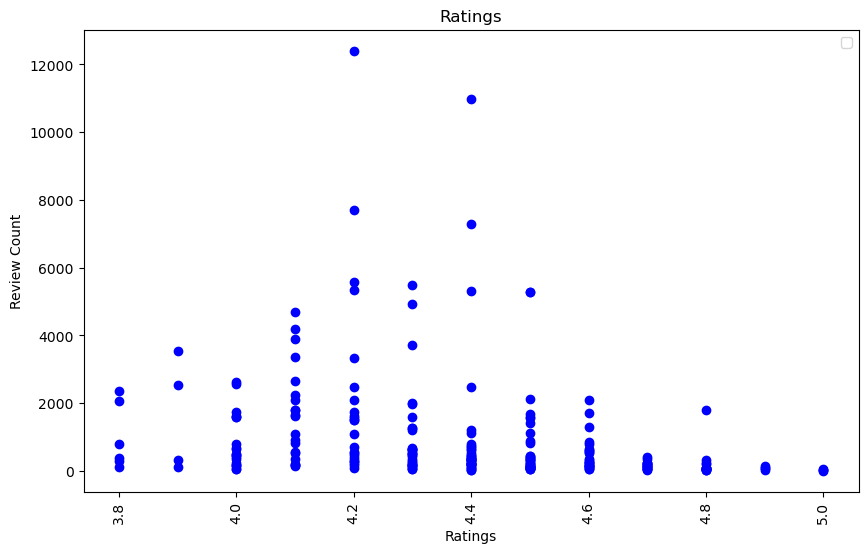

In [25]:
# What does our data look like? 
plt.figure(figsize=(10,6))
plt.scatter(merged_df['Rating'], merged_df['Review_count'], color = 'blue', marker= 'o')
plt.ylabel('Review Count')
plt.xlabel('Ratings')
plt.title('Ratings')
plt.xticks(rotation = 90)
plt.legend()

# plt.grid(True) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


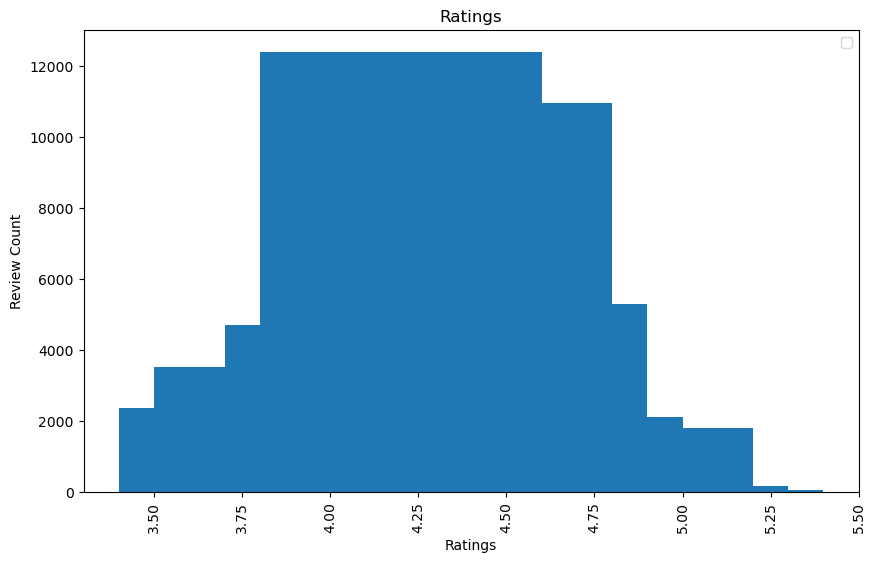

In [45]:
plt.figure(figsize=(10,6))
plt.bar(merged_df['Rating'], merged_df['Review_count'])
plt.ylabel('Review Count')
plt.xlabel('Ratings')
plt.title('Ratings')
plt.xticks(rotation = 90)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


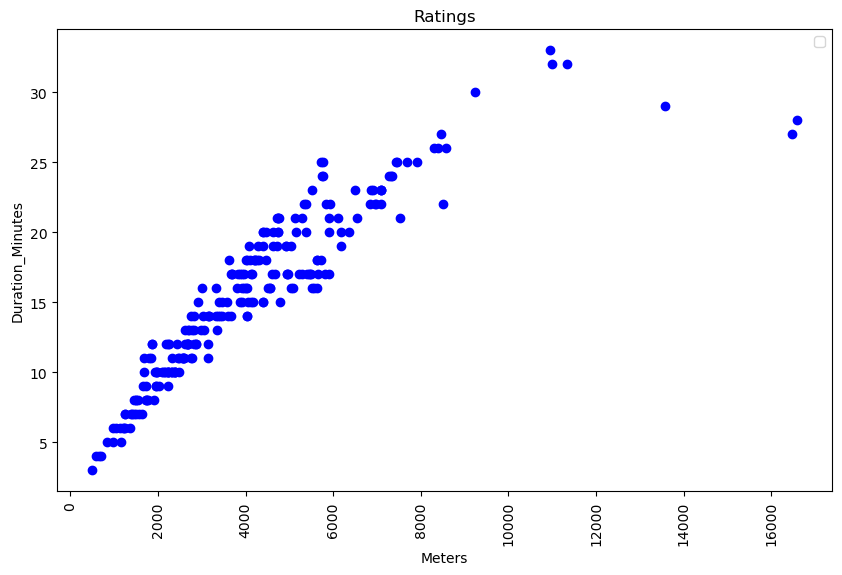

In [27]:
# What does our data look like? 


plt.figure(figsize=(10,6))
plt.scatter(merged_df['Distance_Meters'], merged_df['Duration_Minutes'], color = 'blue', marker= 'o')
plt.ylabel('Duration_Minutes')
plt.xlabel('Meters')
plt.title('Ratings')
plt.xticks(rotation = 90)
plt.legend()
# plt.grid(True) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


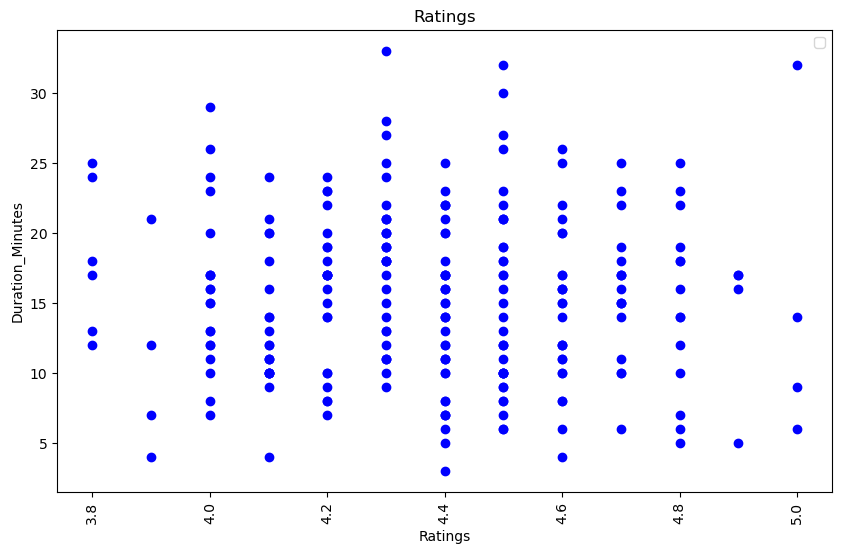

In [46]:

plt.figure(figsize=(10,6))
plt.scatter(merged_df['Rating'], merged_df['Duration_Minutes'], color = 'blue', marker= 'o')
plt.ylabel('Duration_Minutes')
plt.xlabel('Ratings')
plt.title('Ratings')
plt.xticks(rotation = 90)
plt.legend()
# plt.grid(True) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


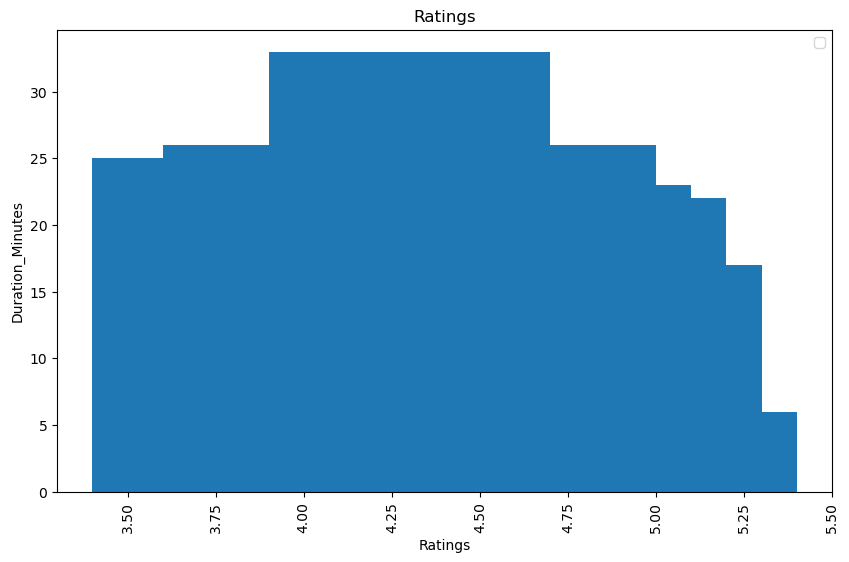

In [32]:
yes_delivery = merged_df[merged_df['Delivery']==True]
yes_delivery


plt.figure(figsize=(10,6))
plt.bar(yes_delivery['Rating'], yes_delivery['Duration_Minutes'])
plt.ylabel('Duration_Minutes')
plt.xlabel('Ratings')
plt.title('Ratings')
plt.xticks(rotation = 90)
plt.legend()
# plt.grid(True) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


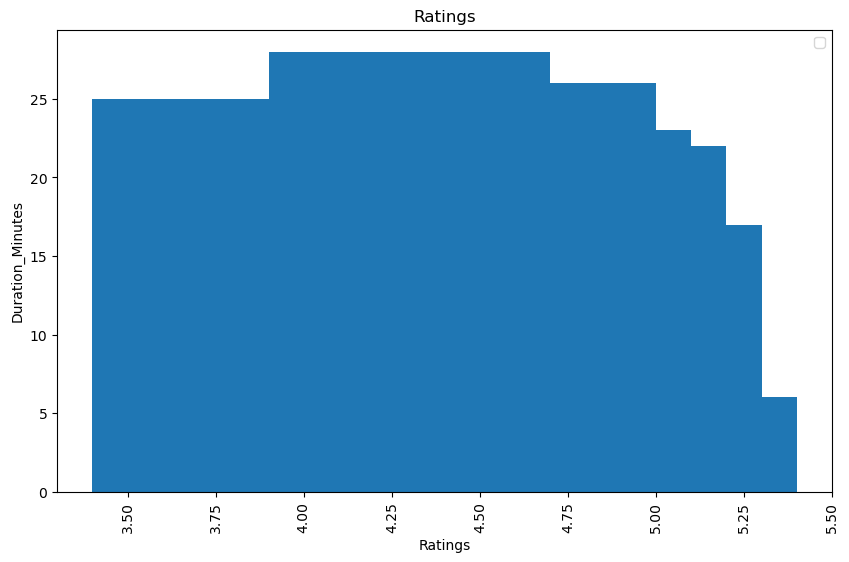

In [39]:
yes_pickup = merged_df[merged_df['Pickup']==True]
yes_pickup


plt.figure(figsize=(10,6))
plt.bar(yes_pickup['Rating'], yes_pickup['Duration_Minutes'])
plt.ylabel('Duration_Minutes')
plt.xlabel('Ratings')
plt.title('Ratings')
plt.xticks(rotation = 90)
plt.legend()
# plt.grid(True) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


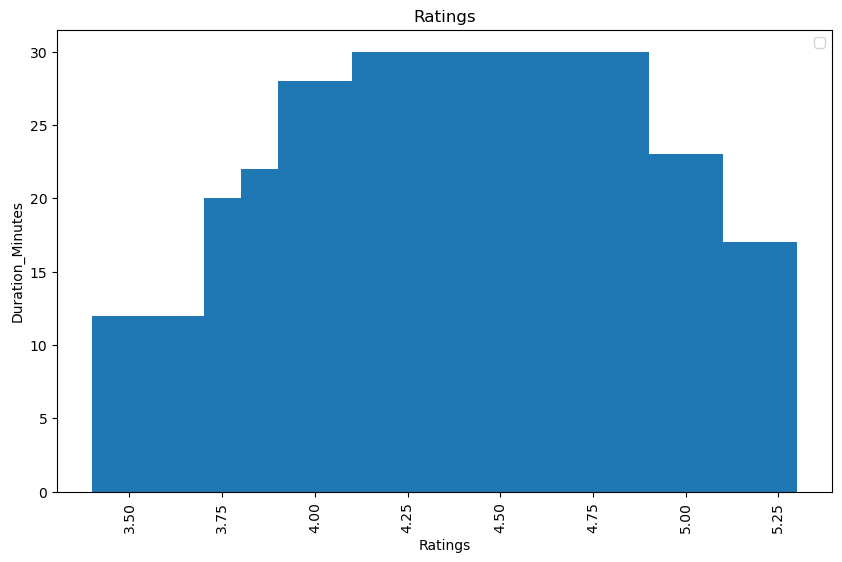

In [37]:
yes_reservation = merged_df[merged_df['Restaurant_Reservation']==True]
yes_reservation


plt.figure(figsize=(10,6))
plt.bar(yes_reservation['Rating'], yes_reservation['Duration_Minutes'])
plt.ylabel('Duration_Minutes')
plt.xlabel('Ratings')
plt.title('Ratings')
plt.xticks(rotation = 90)
plt.legend()
# plt.grid(True) 

Slope: -47.95576010110894
Intercept: 1132.2094314141557
R-squared: 0.001284612818163601
Standard Error: 86.49212622529708


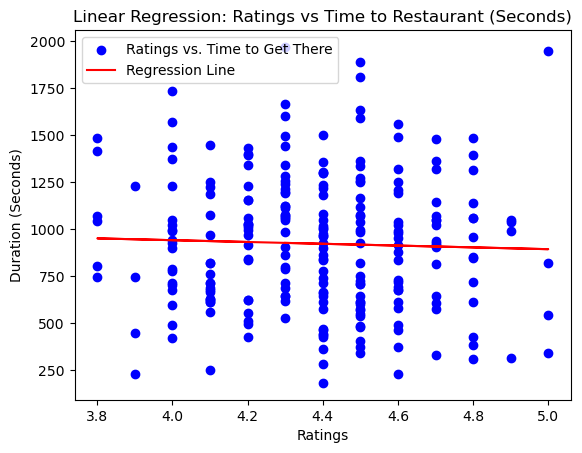

In [50]:
#Regression Analysis (fingers crossed)

X = merged_df['Rating']
y = merged_df['Duration_Seconds']

# Perform linear regression using linregress
slope, intercept, r_value, p_value, std_err = st.linregress(X, y)

#Creating the regression line
regression_line = slope * X + intercept

# Plot the scatter plot and regression line
plt.scatter(X, y, color='blue', label='Ratings vs. Time to Get There')
plt.plot(X, regression_line, color='red', label='Regression Line')

plt.xlabel('Ratings')
plt.ylabel('Duration (Seconds)')
plt.title('Linear Regression: Ratings vs Time to Restaurant (Seconds)')
plt.legend()

# Print the results
print('Slope:', slope)
print('Intercept:', intercept)
print('R-squared:', r_value**2)
print('Standard Error:', std_err)

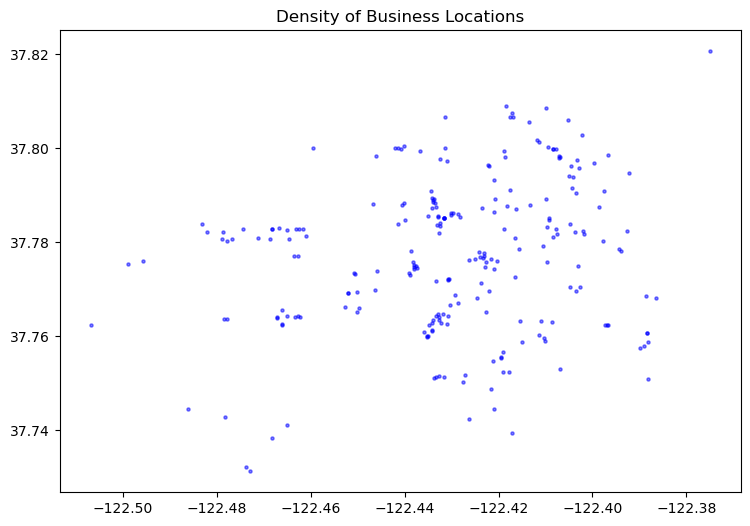

In [54]:
#See if GeoPandas can add anything to this? 
#Business Density 

#Converting merged df into a geopandas GeoDataFrame
geometry = [Point(xy) for xy in zip(merged_df['Longitude'], merged_df['Latitude'])]
geo_df = gpd.GeoDataFrame(merged_df, geometry=geometry)

# Using the KDE (Kernel Density Estimation) approach to visualize the density of businesses
geo_df.plot(marker='o', color='blue', markersize=5, figsize=(10, 6), alpha=0.5)

plt.title('Density of Business Locations')
plt.show()
